**Import packages**

In [1]:
#load packages
import sys #access to system parameters https://docs.python.org/3/library/sys.html
import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
import matplotlib #collection of functions for scientific and publication-ready visualization
import numpy as np #foundational package for scientific computing
import scipy as sp #collection of functions for scientific computing and advance mathematics
import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
import sklearn #collection of machine learning algorithms
#misc libraries
import random
import time
#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output

-------------------------
titanic



**Import model libaries**

In [2]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

from sklearn.model_selection import train_test_split


#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

**Data exploration**

In [3]:
X_raw = pd.read_csv('../input/titanic/train.csv')
X_test_full  = pd.read_csv('../input/titanic/test.csv')

X_full = X_raw.copy()


#seperate the data 
X_full.dropna(axis=0, subset=['Survived'], inplace=True)
#y = X_full.Survived              
#X_full.drop(['Survived'], axis=1, inplace=True)

#split the data first, this prevents data contamination

X_train_full, X_valid_full = train_test_split(X_full, train_size=0.8, test_size=0.2,
                                                                random_state=0)


X_train_full_plus = X_train_full.copy()
X_valid_full_plus = X_valid_full.copy()
X_test_full_plus = X_test_full.copy()

data_cleaner = [X_train_full_plus,X_valid_full_plus,X_test_full_plus]

#gives me the types of data
X_full.info()
X_full.sample(10)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
544,545,0,1,"Douglas, Mr. Walter Donald",male,50.0,1,0,PC 17761,106.4250,C86,C
148,149,0,2,"Navratil, Mr. Michel (""Louis M Hoffman"")",male,36.5,0,2,230080,26.0000,F2,S
73,74,0,3,"Chronopoulos, Mr. Apostolos",male,26.0,1,0,2680,14.4542,NaN,C
594,595,0,2,"Chapman, Mr. John Henry",male,37.0,1,0,SC/AH 29037,26.0000,NaN,S
532,533,0,3,"Elias, Mr. Joseph Jr",male,17.0,1,1,2690,7.2292,NaN,C
860,861,0,3,"Hansen, Mr. Claus Peter",male,41.0,2,0,350026,14.1083,NaN,S
326,327,0,3,"Nysveen, Mr. Johan Hansen",male,61.0,0,0,345364,6.2375,NaN,S
862,863,1,1,"Swift, Mrs. Frederick Joel (Margaret Welles Ba...",female,48.0,0,0,17466,25.9292,D17,S
866,867,1,2,"Duran y More, Miss. Asuncion",female,27.0,1,0,SC/PARIS 2149,13.8583,NaN,C
140,141,0,3,"Boulos, Mrs. Joseph (Sultana)",female,NaN,0,2,2678,15.2458,NaN,C


**Begin data cleaning**

1. correct values that do not seem right... aka age = 200
2. complete missing values
3.create new features, aka do titles play a part in one's survival
4.converting, convert object to categorical dummy variables 

In [4]:
#see which features have null value

print('Train columns with null values:\n', X_full.isnull().sum())
print("-" *10)


print('Test/Validation columns with null values:\n', X_test_full.isnull().sum())
print("-"*10)

X_full.describe(include = 'all')

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Test/Validation columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"O'Sullivan, Miss. Bridget Mary",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Alot of null values in age and cabin and 2 null val for embarked, so lets fill them

# **Finding correlations**

In [5]:
# i used X_raw here as X_full does not have [Survived]/ target value
# does wealth have an impact on survival ?
X_raw[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [6]:
X_raw[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [7]:
X_raw[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)


,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [8]:
X_raw[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


# Vizualize data 

Lets correlate numerical features

Which age category plays a role to survival ?

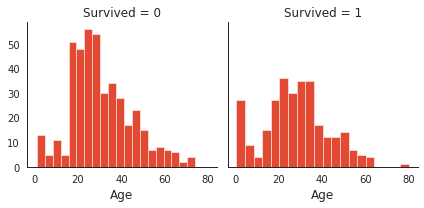

In [9]:
g = sns.FacetGrid(X_raw, col='Survived')
g.map(plt.hist, 'Age', bins=20)

It seems most infants survived, the oldest passenger(s) survived and people between 20-40 were most susceptible

We should try finding correlation between ordinal and numerical values

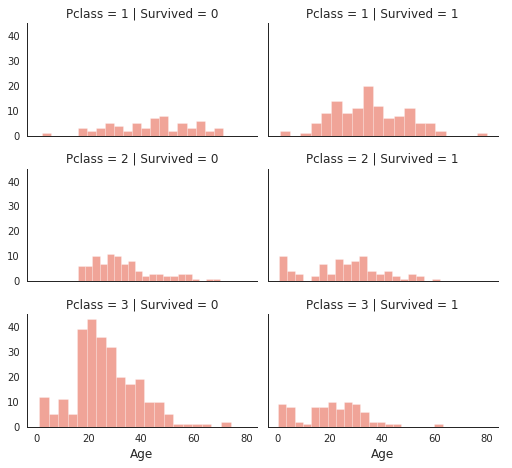

In [10]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(X_raw, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();


Most babies survived, passanges in parch 1, most survived. We should use age


Lets try correlating categorical features

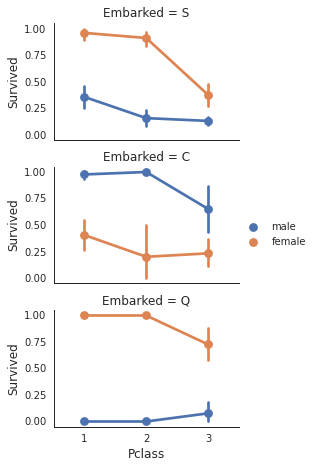

In [11]:
grid = sns.FacetGrid(X_raw, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

Where they embarked affected survival rate

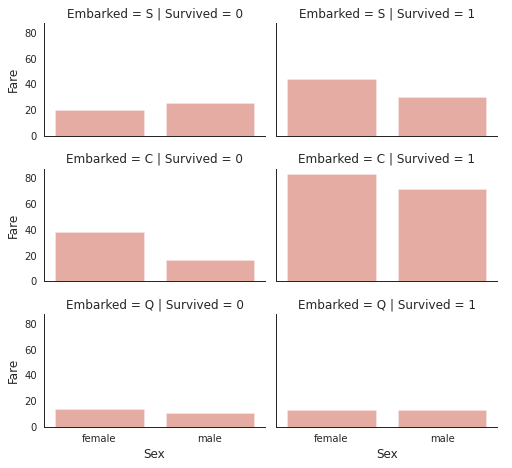

In [12]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(X_raw, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

higher fare correlates with survival

# Create new features

I use some regex to get titles of passengers

In [13]:
for dataset in data_cleaner:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(X_train_full_plus['Title'], X_train_full_plus['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,1
Countess,1,0
Dr,0,3
Lady,1,0
Major,0,2
Master,0,35
Miss,145,0
Mlle,2,0


In [14]:
for dataset in data_cleaner:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
X_train_full_plus[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.571429
1,Miss,0.709459
2,Mr,0.155131
3,Mrs,0.793814
4,Rare,0.461538


In [15]:
# Fill in missing data appropriately
for dataset in data_cleaner:    
    #complete missing age with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    #complete embarked with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    #complete missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
#[X_train_full_plus,X_valid_full_plus,X_test_full_plus]
#drop irrelevant columns
#drop_column = ['PassengerId','Cabin', 'Ticket']
drop_column = ['Cabin', 'Ticket']
X_train_full_plus.drop(drop_column, axis=1, inplace = True)
X_valid_full_plus.drop(drop_column, axis=1, inplace = True)
X_test_full_plus.drop(drop_column, axis=1, inplace = True)

Converting titles to ordinal data 

In [16]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in data_cleaner:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

X_train_full_plus.head(100)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
140,141,0,3,"Boulos, Mrs. Joseph (Sultana)",female,29.0,0,2,15.2458,C,3
439,440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,10.5000,S,1
817,818,0,2,"Mallet, Mr. Albert",male,31.0,1,1,37.0042,C,1
378,379,0,3,"Betros, Mr. Tannous",male,20.0,0,0,4.0125,C,1
491,492,0,3,"Windelov, Mr. Einar",male,21.0,0,0,7.2500,S,1
...,...,...,...,...,...,...,...,...,...,...,...
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,247.5208,C,1
12,13,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,8.0500,S,1
157,158,0,3,"Corn, Mr. Harry",male,30.0,0,0,8.0500,S,1
127,128,1,3,"Madsen, Mr. Fridtjof Arne",male,24.0,0,0,7.1417,S,1


In [17]:
drop_column_2 = ['Name']
X_train_full_plus.drop(drop_column_2, axis=1, inplace = True)
X_valid_full_plus.drop(drop_column_2, axis=1, inplace = True)
X_test_full_plus.drop(drop_column_2, axis=1, inplace = True)


In [18]:
X_train_full_plus.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
140,141,0,3,female,29.0,0,2,15.2458,C,3
439,440,0,2,male,31.0,0,0,10.5000,S,1
817,818,0,2,male,31.0,1,1,37.0042,C,1
378,379,0,3,male,20.0,0,0,4.0125,C,1
491,492,0,3,male,21.0,0,0,7.2500,S,1


In [19]:
X_train_full_plus.shape,X_valid_full_plus.shape,X_test_full_plus.shape

((712, 10), (179, 10), (418, 9))

In [20]:
X_test_full_plus.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,male,34.5,0,0,7.8292,Q,1
1,893,3,female,47.0,1,0,7.0000,S,3
2,894,2,male,62.0,0,0,9.6875,Q,1
3,895,3,male,27.0,0,0,8.6625,S,1
4,896,3,female,22.0,1,1,12.2875,S,3


Convert gender to numerical

In [21]:
for dataset in data_cleaner:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)


Combining features of sibling and parch to family size

In [22]:
  for dataset in data_cleaner:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

X_train_full_plus[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.680000
2,3,0.555556
1,2,0.539683
6,7,0.363636
0,1,0.311628
5,6,0.214286
4,5,0.153846
7,8,0.000000
8,11,0.000000


In [23]:
for dataset in data_cleaner:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

X_train_full_plus[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.492908
1,1,0.311628


In [24]:
#drop values
X_train_full_plus = X_train_full_plus.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
X_valid_full_plus =X_valid_full_plus.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
X_test_full_plus =X_test_full_plus.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)




In [25]:
data_cleaner = [X_train_full_plus,X_valid_full_plus,X_test_full_plus]
X_train_full_plus.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
140,141,0,3,1,29.0,15.2458,C,3,0
439,440,0,2,0,31.0,10.5000,S,1,1
817,818,0,2,0,31.0,37.0042,C,1,0
378,379,0,3,0,20.0,4.0125,C,1,1
491,492,0,3,0,21.0,7.2500,S,1,1


Convert ports (categorical) to numerical 

In [26]:
for dataset in data_cleaner:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)



In [27]:
X_train_full_plus.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
140,141,0,3,1,29.0,15.2458,1,3,0
439,440,0,2,0,31.0,10.5000,0,1,1
817,818,0,2,0,31.0,37.0042,1,1,0
378,379,0,3,0,20.0,4.0125,1,1,1
491,492,0,3,0,21.0,7.2500,0,1,1


In [28]:
for dataset in data_cleaner:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)


data_cleaner = [X_train_full_plus, X_valid_full_plus,X_test_full_plus]
    
X_train_full_plus.head(10)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
140,141,0,3,1,29.0,2,1,3,0
439,440,0,2,0,31.0,1,0,1,1
817,818,0,2,0,31.0,3,1,1,0
378,379,0,3,0,20.0,0,1,1,1
491,492,0,3,0,21.0,0,0,1,1
331,332,0,1,0,45.5,2,0,1,1
588,589,0,3,0,22.0,1,0,1,1
358,359,1,3,1,29.0,0,2,2,1
674,675,0,2,0,29.0,0,0,1,1
162,163,0,3,0,26.0,0,0,1,1


In [29]:
#train set seperate
Y_train = X_train_full_plus["Survived"]
X_train_full_plus = X_train_full_plus.drop("Survived", axis=1)
#Valid set seperate
Y_valid = X_valid_full_plus["Survived"]
X_valid_full_plus = X_valid_full_plus.drop("Survived", axis=1)


X_train_full_plus.shape, Y_train.shape, X_valid_full_plus.shape, X_test_full_plus.shape



((712, 8), (712,), (179, 8), (418, 8))

In [30]:
X_valid_full_plus.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
495,496,3,0,27.0,2,1,1,1
648,649,3,0,27.0,0,0,1,1
278,279,3,0,7.0,2,2,4,0
31,32,1,1,27.0,3,1,3,0
255,256,3,1,29.0,2,1,3,0


# Model building

In [31]:
# Define the model
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error

my_model = XGBClassifier(n_estimators=1000, learning_rate=0.05, n_jobs=4)
# Fit the model

my_model.fit(X_train_full_plus, Y_train,
              early_stopping_rounds=10,
              eval_set=[(X_valid_full_plus, Y_valid)],
              verbose=False)


#Get predictions
predictions = my_model.predict(X_valid_full_plus) # Your code here

# Calculate MAE
#mae = mean_absolute_error(predictions, Y_valid) # Your code here

#Uncomment to print MAE
#print("Mean Absolute Error:" , mae)

predictions = my_model.predict(X_test_full_plus) # Your code here

In [32]:
output = pd.DataFrame({'PassengerId': X_test_full_plus.PassengerId, 'Survived': predictions})
output.to_csv('XGBoostver3.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


I based my approach on popular tutorials, ironically my aproach of simply using a one-hot encoder, discarding features with high cardinality and no feature engineering produces a higher results. This could be atrributed due to over feature engineering and discarding important features. A better version might be to use regularization instead deal with noise instead over-feature engineering. 